In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 불러오기
data = pd.read_csv('../data/test11.csv', encoding='cp949')  # 데이터 파일 경로에 맞게 수정하세요.

# 수온 열 선택
temperature = data['평균 수온(°C)'].values.reshape(-1, 1)

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature)

# 데이터셋 생성
look_back = 7  # 과거 시간 단위 설정
X, Y = [], []
for i in range(len(temperature_scaled) - look_back):
    X.append(temperature_scaled[i:i+look_back, 0])
    Y.append(temperature_scaled[i+look_back, 0])
X = np.array(X)
Y = np.array(Y)

# 데이터셋 분할 (훈련 데이터와 테스트 데이터)
train_size = int(len(X) * 0.8)  # 전체 데이터 중 80%를 훈련 데이터로 사용
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 훈련
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# 모델 평가
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# 예측 수온 계산
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 스케일 역변환
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# 결과 출력
print('Train RMSE:', np.sqrt(np.mean((train_predict - Y_train)**2)))
print('Test RMSE:', np.sqrt(np.mean((test_predict - Y_test)**2)))

Epoch 1/100
2856/2856 - 7s - loss: nan - 7s/epoch - 2ms/step
Epoch 2/100
2856/2856 - 5s - loss: nan - 5s/epoch - 2ms/step
Epoch 3/100
2856/2856 - 5s - loss: nan - 5s/epoch - 2ms/step
Epoch 4/100
2856/2856 - 5s - loss: nan - 5s/epoch - 2ms/step
Epoch 5/100
2856/2856 - 5s - loss: nan - 5s/epoch - 2ms/step
Epoch 6/100


KeyboardInterrupt: 

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 데이터 불러오기
data = pd.read_csv('../data/test11.csv', encoding='cp949')  # 데이터 파일 경로에 맞게 수정하세요.

# 데이터가 0인 행 제거
data = data.loc[data['평균 수온(°C)'] != 0]

# 0을 NaN으로 대체
data['평균 수온(°C)'] = data['평균 수온(°C)'].replace(0, np.nan)

# NaN을 포함하는 행 제거
data = data.dropna()

# 수온 열 선택
temperature = data['평균 수온(°C)'].values.reshape(-1, 1)

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature)

# 데이터셋 생성
class TemperatureDataset(Dataset):
    def __init__(self, data, look_back):
        self.X, self.Y = [], []
        for i in range(len(data) - look_back):
            self.X.append(data[i:i+look_back, 0])
            self.Y.append(data[i+look_back, 0])
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

look_back = 7  # 과거 시간 단위 설정
dataset = TemperatureDataset(temperature_scaled, look_back)

# 데이터셋 분할 (훈련 데이터와 테스트 데이터)
train_size = int(len(dataset) * 0.8)  # 전체 데이터 중 80%를 훈련 데이터로 사용
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

# 데이터 로더 생성
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x.view(len(x), 1, -1), (h0, c0))
        out = self.fc(out.view(len(out), -1))
        return out[-1]

input_size = 1
hidden_size = 50
output_size = 1

In [8]:
# 모델 초기화 및 장치 설정
model = LSTMModel(input_size, hidden_size, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        
        # Forward 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward 및 경사도 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

# 모델 평가
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        
        # Forward 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 7

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 데이터 로드 및 전처리
df = pd.read_csv('../data/test11.csv', encoding='cp949')
df = df[['일시', '평균 수온(°C)']]
df.loc[df['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
df = df.dropna()

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_data = df['평균 수온(°C)'].values.reshape(-1, 1)
scaled_data = scaler_x.fit_transform(scaled_data)


# 시계열 데이터를 입력과 출력으로 변환
def build_dataset(time_series, seq_length):
    data_X = []
    data_Y = []

    for i in range(len(time_series) - seq_length):
        x = time_series[i:i+seq_length, :]
        y = time_series[i+seq_length, :]
        data_X.append(x)
        data_Y.append(y)

    return np.array(data_X), np.array(data_Y)

seq_length = 7
train_size = int(len(scaled_data) * 0.8)
train_set = scaled_data[:train_size]
test_set = scaled_data[train_size-seq_length:]

train_X, train_Y = build_dataset(train_set, seq_length)
test_X, test_Y = build_dataset(test_set, seq_length)

train_X_tensor = torch.FloatTensor(train_X)
train_Y_tensor = torch.FloatTensor(train_Y)

test_X_tensor = torch.FloatTensor(test_X)
test_Y_tensor = torch.FloatTensor(test_Y)

train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# LSTM 모델 정의
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, num_layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_dim = train_X_tensor.shape[-1]
output_dim = 1
hidden_dim = 32
num_layers = 2
learning_rate = 0.001
num_epochs = 100

model = Net(input_dim, hidden_dim, seq_length, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')


Epoch [10/100], Train Loss: 0.0018
Epoch [20/100], Train Loss: 0.0012
Epoch [30/100], Train Loss: 0.0011
Epoch [40/100], Train Loss: 0.0012
Epoch [50/100], Train Loss: 0.0011
Epoch [60/100], Train Loss: 0.0011
Epoch [70/100], Train Loss: 0.0011
Epoch [80/100], Train Loss: 0.0011
Epoch [90/100], Train Loss: 0.0011
Epoch [100/100], Train Loss: 0.0011


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte

In [16]:
# 모델 평가
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

# 예측 결과 시각화
predicted = model(test_X_tensor.to(device)).cpu().detach().numpy()
predicted = scaler_y.inverse_transform(predicted.reshape(-1, 1)).flatten()

plt.plot(test_set, label='Actual')
plt.plot(range(seq_length, len(test_set)+seq_length), predicted, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Test Loss: 0.0011


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 데이터 로드 및 전처리
df = pd.read_csv('../data/test11.csv', encoding='cp949')
df = df[['일시', '평균 수온(°C)']]
df.loc[df['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
df = df.dropna()

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_data_x = scaler_x.fit_transform(train_X)
scaled_data_y = scaler_y.fit_transform(train_Y)

train_X_tensor = torch.FloatTensor(scaled_data_x)
train_Y_tensor = torch.FloatTensor(scaled_data_y)

# LSTM 모델 정의
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, num_layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

# 모델 초기화
input_dim = 1
hidden_dim = 10
output_dim = 1
num_layers = 2

model = Net(input_dim, hidden_dim, seq_length, output_dim, num_layers)

# LSTM 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')

# 예측 결과 시각화
model.eval()
predicted = model(test_X_tensor.to(device)).cpu().detach().numpy()
predicted = scaler_y.inverse_transform(predicted.reshape(-1, 1)).flatten()

plt.plot(test_set, label='Actual')
plt.plot(range(seq_length, len(test_set)+seq_length), predicted, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 데이터 로드 및 전처리
df = pd.read_csv('../data/test11.csv', encoding='cp949')
df = df[['일시', '평균 수온(°C)']]
df.loc[df['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
df = df.dropna()

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_data = df['평균 수온(°C)'].values.reshape(-1, 1)
scaled_data = scaler_x.fit_transform(scaled_data)

# 시계열 데이터를 입력과 출력으로 변환
def build_dataset(time_series, seq_length):
    data_X = []
    data_Y = []

    for i in range(len(time_series) - seq_length):
        x = time_series[i:i+seq_length, :]
        y = time_series[i+seq_length, :]
        data_X.append(x)
        data_Y.append(y)

    return np.array(data_X), np.array(data_Y)

seq_length = 7
train_size = int(len(scaled_data) * 0.8)
train_set = scaled_data[:train_size]
test_set = scaled_data[train_size-seq_length:]
test_set = scaled_data[train_size-seq_length:]

# Fit scaler_y to train_set
scaler_y.fit(train_set)

train_X, train_Y = build_dataset(train_set, seq_length)
test_X, test_Y = build_dataset(test_set, seq_length)

train_X_tensor = torch.FloatTensor(train_X)
train_Y_tensor = torch.FloatTensor(train_Y)

test_X_tensor = torch.FloatTensor(test_X)
test_Y_tensor = torch.FloatTensor(test_Y)

train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# LSTM 모델 정의
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, num_layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = train_X_tensor.shape[-1]
output_dim = 1
hidden_dim = 32
num_layers = 2
learning_rate = 0.001
num_epochs = 100
batch_size = 64

model = Net(input_dim, hidden_dim, seq_length, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')


Epoch [10/100], Train Loss: 0.0026
Epoch [20/100], Train Loss: 0.0023
Epoch [30/100], Train Loss: 0.0018
Epoch [40/100], Train Loss: 0.0014
Epoch [50/100], Train Loss: 0.0013
Epoch [60/100], Train Loss: 0.0011
Epoch [70/100], Train Loss: 0.0011
Epoch [80/100], Train Loss: 0.0011
Epoch [90/100], Train Loss: 0.0011
Epoch [100/100], Train Loss: 0.0011


Test Loss: 0.0011


ValueError: x and y must have same first dimension, but have shapes (714,) and (707,)

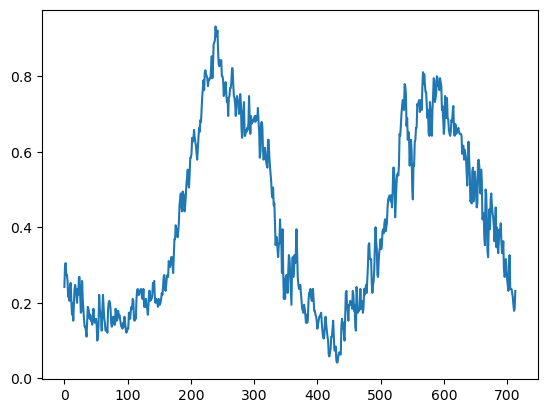

In [30]:
# 모델 평가
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

# 예측 결과 시각화
predicted = model(test_X_tensor.to(device)).cpu().detach().numpy()
predicted = scaler_y.inverse_transform(predicted.reshape(-1, 1)).flatten()

plt.plot(test_set, label='Actual')
plt.plot(range(seq_length, seq_length+len(test_set)), predicted[:len(test_set)], label='Predicted')
# plt.plot(range(seq_length, len(test_set)+seq_length), predicted[:len(test_set)], label='Predicted')
# plt.plot(range(seq_length, len(test_set)+seq_length), predicted, label='Predicted')
# plt.plot(range(len(test_set)), predicted[:len(test_set)], label='Predicted')
# plt.plot(range(len(test_set)), predicted, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 데이터 로드 및 전처리
df = pd.read_csv('../data/test11.csv', encoding='cp949')
df = df[['일시', '평균 수온(°C)']]
df.loc[df['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
df = df.dropna()

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_data = df['평균 수온(°C)'].values.reshape(-1, 1)
scaled_data = scaler_x.fit_transform(scaled_data)

# 시계열 데이터를 입력과 출력으로 변환
def build_dataset(time_series, seq_length):
    data_X = []
    data_Y = []

    for i in range(len(time_series) - seq_length):
        x = time_series[i:i+seq_length, :]
        y = time_series[i+seq_length, :]
        data_X.append(x)
        data_Y.append(y)

    return np.array(data_X), np.array(data_Y)

seq_length = 7
train_size = int(len(scaled_data) * 0.8)
train_set = scaled_data[:train_size]
test_set = scaled_data[train_size-seq_length:]

# Fit scaler_y to train_set
scaler_y.fit(train_set)

train_X, train_Y = build_dataset(train_set, seq_length)
test_X, test_Y = build_dataset(test_set, seq_length)

train_X_tensor = torch.FloatTensor(train_X)
train_Y_tensor = torch.FloatTensor(train_Y)

test_X_tensor = torch.FloatTensor(test_X)
test_Y_tensor = torch.FloatTensor(test_Y)

train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [32]:
# LSTM 모델 정의
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, num_layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = train_X_tensor.shape[-1]
output_dim = 1
hidden_dim = 32
num_layers = 2
learning_rate = 0.001
num_epochs = 100
batch_size = 64

model = Net(input_dim, hidden_dim, seq_length, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [33]:
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')



Epoch [10/100], Train Loss: 0.0024
Epoch [20/100], Train Loss: 0.0020
Epoch [30/100], Train Loss: 0.0015
Epoch [40/100], Train Loss: 0.0012
Epoch [50/100], Train Loss: 0.0012
Epoch [60/100], Train Loss: 0.0011
Epoch [70/100], Train Loss: 0.0011
Epoch [80/100], Train Loss: 0.0011
Epoch [90/100], Train Loss: 0.0011
Epoch [100/100], Train Loss: 0.0011


Test Loss: 0.0012


ValueError: x and y must have same first dimension, but have shapes (714,) and (707,)

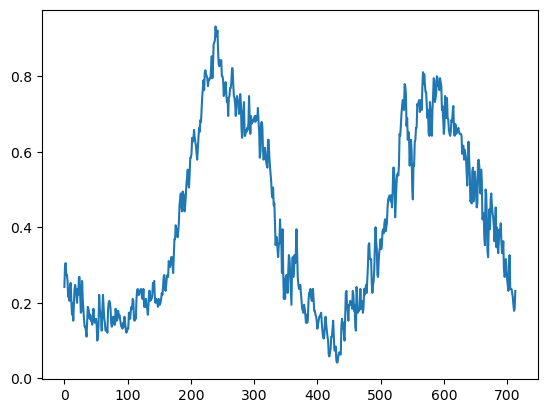

In [34]:
# 모델 평가
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

# 예측 결과 시각화
predicted = model(test_X_tensor.to(device)).cpu().detach().numpy()
predicted = scaler_y.inverse_transform(predicted.reshape(-1, 1)).flatten()

plt.plot(test_set, label='Actual')
plt.plot(range(seq_length, seq_length+len(test_set)), predicted[:len(test_set)], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()